In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import scipy

## ZigZag sampler

In [2]:
def random_time(a,b,y):
    if b == 0:
        if a > 0:
            return np.log(y)/(-float(a))
        else:
            return -1
    elif b > 0:
        if a >= 0:
            return -a/float(b) + np.sqrt(a**2/float(b**2) - 2*np.log(y)/float(b))
        else:
            return -a/float(b) + random_time(0,b,y)
    else:
        if a > 0:
            if np.log(y) >= a**2/float(2*b):
                return -a/float(b) - np.sqrt(a**2/float(b**2) - 2*np.log(y)/float(b))
            else:
                return -1
        else:
            return -1

In [3]:
class ZigZag:
    def __init__(self,dim,x0,mu,V,final_time,boundary = None):
        self.dim = dim
        self.x0 = x0
        self.mu = mu
        self.V = V
        self.final_time = final_time
        self.boundary = boundary
        self.simulation = self._simulation()

    def description(self):
        print("We are trying to sample from a normal distribution in", self.dim, "-d, with mean", self.mu, "and variance", self.V)
    
    def _simulation(self):
        current_time = 0
        k = 1

        # Initialize dataframes
        T = pd.DataFrame(columns = ['T'])
        X = pd.DataFrame(columns = range(self.dim))
        theta = pd.DataFrame(columns = range(self.dim))

        # Initial values
        T.loc[1] = 0
        X.loc[1,:] = self.x0
        theta.loc[1,:] = [1]*self.dim
        tau = -1

        while (current_time < self.final_time):

            # Draw uniform r.v. for switching time and acceptance of new switching time
            R = np.random.uniform(0,1,[1,1+self.dim])
            i0 = -1

            for i in range(0,self.dim):
                a = theta.loc[k,i]*np.dot(self.V[i,:],(X.loc[k,:].values-self.mu))
                b = theta.loc[k,i]*np.dot(self.V[i,:],theta.loc[k,:].values)
                simulated_time = random_time(a,b,R[0,i])
                
                if self.boundary is not None:
                    u = max((self.boundary[i]-X.loc[k,i])/float(theta.loc[k,i]),0)
                    if (u>0):
                        simulated_time = min(u,simulated_time)
            
                if (simulated_time > 0) & ((i0 == -1) | (simulated_time < tau)):
                    tau = simulated_time
                    i0 = i

            if tau == -1:
                print('Infinity')
                break

            # Update time, path and velocity
            T.loc[k+1] = T.loc[k] + tau
            X.loc[k+1,:] = X.loc[k,:] + theta.loc[k,:]*tau
            theta.loc[k+1,:] = theta.loc[k,:]
            theta.loc[k+1,i0] = -1*theta.loc[k,i0]

            k = k+1
            current_time = T.loc[k].item()
            
        return T,X,theta

    def mean_and_covariance(self):
        T,X,theta = self.simulation
        d = X.shape[1]
        n_points = T.shape[0]

        k = 2
        means = np.zeros(d)
        covariance = np.zeros((d,d))
        T_max = T.loc[n_points,'T']

        t_prev= T.loc[k-1,'T']
        x_prev= X.loc[k-1,:].values

        while k <= n_points:
            t_now = T.loc[k,'T']
            x_now = X.loc[k,:].values

            means = means + (t_now-t_prev)*(x_prev+x_now)/(float(2)*T_max)
            covariance = covariance + (t_now-t_prev)*((1/(float(6)*T_max))*(2*np.multiply.outer(x_now,x_now) + np.multiply.outer(x_now,x_prev) + np.multiply.outer(x_prev,x_now) + 2*np.multiply.outer(x_prev,x_prev)))
            t_prev = t_now
            x_prev = x_now
            k = k+1

        covariance = covariance - np.multiply.outer(means,means)

        return means, covariance
    
    def plot_path(self):
        T,X,theta = self.simulation
        if self.dim == 1:
            plt.xlabel('t')
            plt.ylabel('X')
            plt.plot(T,X)
        elif self.dim == 2:
            plt.xlabel('X1(t)')
            plt.ylabel('X2(t)')
            plt.plot(X.loc[:,0], X.loc[:,1])
        
        plt.grid(True)
        plt.show()
        
    def sample_traj(self,m):
        T,X,theta = self.simulation
        n_points = T.shape[0]-1
        tau = T.loc[n_points,'T']
        dim = X.shape[1]
        sample = pd.DataFrame(columns = range(dim))

        for i in range(1,m):
            t = i*tau/m
            index = np.argmax(T.loc[:,'T']>t)-1
            traj = X.iloc[index,:].values+(t-(T.loc[index,'T']))*np.int64(theta.iloc[index,:].values)
            sample.loc[i,:] = traj
        return sample

In [4]:
np.random.seed(19234)

In [5]:
zigzag = ZigZag(2,np.array([1,0]),np.array([[10,2],[2,10]]),300)
zigzag.description()

('We are trying to sample from a normal distribution in', 2, '-d, with mean', array([1, 0]), 'and variance', array([[10,  2],
       [ 2, 10]]))


Compute the mean and variance and compare this with the theoretical values.

In [6]:
means, covariance = zigzag.mean_and_covariance()
print(means)
print(covariance)


[ 1.00944519 -0.02276779]
[[ 0.08958404 -0.01513351]
 [-0.01513351  0.10201101]]


This is the theoretical value for the covariance matrix (and coincides with the one found empirically).

In [7]:
np.linalg.inv(np.array([[10,2],[2,10]]))

array([[ 0.10416667, -0.02083333],
       [-0.02083333,  0.10416667]])

In [8]:
s = zigzag.sample_traj(10000)
np.cov(s.loc[:,0],s.loc[:,1])

C:\Users\mark\Anaconda3\envs\master_thesis\lib\site-packages\numpy\core\fromnumeric.py:973: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return argmax(axis, out)


array([[0.1950877820694001, -0.006794218013387374],
       [-0.006794218013387374, 0.23054512657368692]], dtype=object)

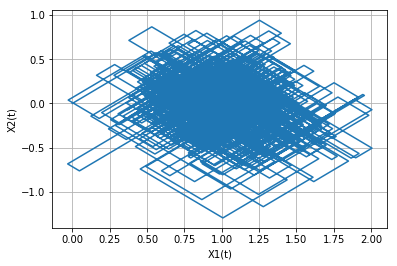

In [9]:
zigzag.plot_path()

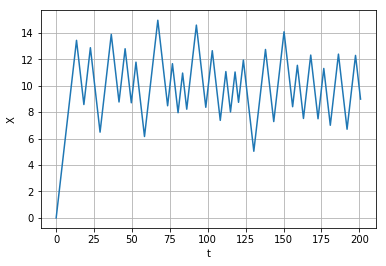

In [7]:
zz = ZigZag(1,np.array([10]),np.array([[1/float(4)]]),200)
zz.plot_path()

In [11]:
zz.mean_and_covariance()

(array([ 9.88904003]), array([[ 4.73134115]]))

In [4]:
from scipy.stats import norm

Introduce the mean and variance of a truncated normal distribution

In [5]:
def cond_mean(mu,sigma,left_boundary):
    z = (left_boundary-mu)/sigma
    Z = 1-norm.cdf(z)
    return mu + sigma*norm.pdf(z)/Z

In [6]:
def cond_var(mu,sigma,left_boundary):
    z = (left_boundary-mu)/sigma
    Z = 1-norm.cdf(z)
    return sigma**2*(1+(z*norm.pdf(z))/Z)-sigma**2*(norm.pdf(z)/Z)**2

In [7]:
def var_xp(R):
    z = math.erfc(R/np.sqrt(2))
    g = math.gamma(3.0/2)*(1-scipy.special.gammainc(3.0/2, R**2/2))
    return 2*(-np.exp(-R**2)+np.sqrt(np.pi)*z*g)/(np.pi*z**2)

In [21]:
cond_mean(np.array([0]),np.array([1]),np.array([2]))

array([ 2.37321553])

Let's display some plots for the Zig-Zag sampler with boundaries.

In [32]:
R=64
zz1 = ZigZag(1,np.array([R+0.1]),np.array([0]),np.array([[1]]),100,boundary = [R])
#zz1.mean_and_covariance()

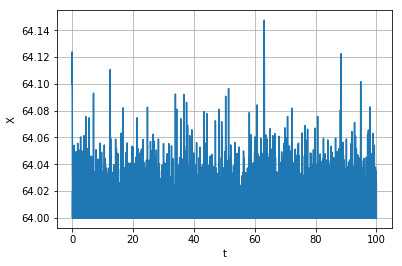

In [33]:
zz1.plot_path()

In [8]:
def mse_ZZ(mu,sigma,T=1000,R=1,k=10):
    x0 = np.array([R])
    mean = []
    all_means = []
    t = np.linspace(1,T,20)
    #tau = T*float(R)
    
    for int_t in t:
        for i in range(k):
            zz1 = ZigZag(1,x0,mu,sigma,int_t,boundary = [R])
            m,c = zz1.mean_and_covariance()
            exp_m = cond_mean(mu,sigma,R)
            mean.append(np.abs(m-exp_m)/np.sqrt(cond_var(mu,sigma,R)))#var_xp(R)))
        all_means.append(np.mean(mean))
    return all_means

In [9]:
mu = np.array([0])
sigma = np.array([[1]])
T = 1000
me = mse_ZZ(mu,sigma,T,R=0.1,k=10)

In [10]:
me

[0.31501498764104463,
 0.68223353030653899,
 0.78321537442575317,
 0.84735385402753194,
 0.87247728636939703,
 0.91830918685009089,
 0.94917403025242009,
 0.97791142627983763,
 0.98622799778917059,
 1.0051004453085068,
 1.0253539491613757,
 1.034651340768348,
 1.0477542128546327,
 1.0574716290275139,
 1.0597820734962671,
 1.0637862826841464,
 1.0699010417922354,
 1.0729287063151884,
 1.0776232344998542,
 1.0802576008213678]

In [11]:
me2 = mse_ZZ(mu,sigma,T,R=0.5,k=10)

In [12]:
me3 = mse_ZZ(mu,sigma,T,R=1,k=10)
me4 = mse_ZZ(mu,sigma,T,R=2,k=10)
me5 = mse_ZZ(mu,sigma,T,R=4,k=10)

In [13]:
me6 = mse_ZZ(mu,sigma,T,R=6,k=10)

In [54]:
R = np.linspace(1,6,5)
mu = np.array([0])
sigma = np.array([[1]])
T = 100
all_means = []
all_variances = []

for r in R:
    means,variances = mse_ZZ(mu,sigma,T,r,k=10)
    all_means.append(means)
    all_variances.append(variances)

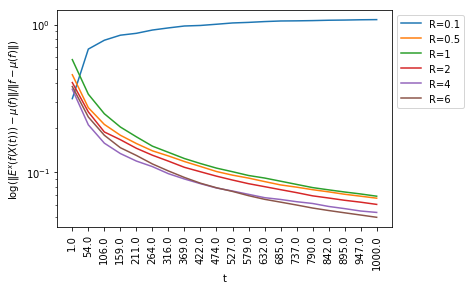

In [22]:
plt.plot(me,label=('R=0.1'))
plt.plot(me2,label=('R=0.5'))
plt.plot(me3,label=('R=1'))
plt.plot(me4,label=('R=2'))
plt.plot(me5,label=('R=4'))
plt.plot(me6,label=('R=6'))
plt.yscale("log")
plt.ylabel('log$(\Vert E^x(f(X(t)))-\mu(f)\Vert/\Vert f-\mu(f) \Vert)$')
plt.xticks(range(0,20),np.round(np.linspace(1,1000,20)),rotation = 90)
plt.xlabel('t')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()

In [43]:
from sklearn.linear_model import LinearRegression

In [59]:
regressor = LinearRegression()  
regressor.fit(np.array(np.linspace(1,100,10)).reshape(-1,1),np.log(me)) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [60]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

-1.76273158829
[-0.0082361]


## Bouncy particle sampler

In [3]:
def tau_bounce_sphere(x,v,r,C):
    D = (2*(np.dot(v,x-C)))**2 - 4*np.dot(v,v)*(np.dot(x-C,x-C)-r**2)
    if (D<0):
        tau = np.nan
    elif (D==0):
        tau = -(np.dot(v,x-C))/(np.dot(v,v))
    else:
        tau = min((-2*np.dot(v,x-C) + np.sqrt(D))/(2*np.dot(v,v)),(-2*np.dot(v,x-C) - np.sqrt(D))/(2*np.dot(v,v)))
    return tau

In [4]:
def resample_velocity(dim):
    mean = [0]*dim
    cov = np.eye(dim)
    return np.random.multivariate_normal(mean,cov)

In [5]:
def flip_BPS(x,v,mu,V):
    gradient = np.dot(V,(x-mu))
    return v-2*((np.dot(v,gradient))/float((np.dot(gradient,gradient))))*gradient

In [6]:
def reflection(v,n):
    """Return specular reflection"""
    return v-2*(np.dot(v,n)/float((np.dot(n,n))))*n

In [7]:
def normal_sphere(x_hit,C):
    """Return normal for incoming vector on sphere"""
    return x_hit-C

In [8]:
class BPS():
    def __init__(self,x0,dim,mu,V,final_time,boundary = np.array([[0,0],1])):
        self.dim = dim
        self.x0 = x0
        self.mu = mu
        self.V = V
        self.final_time = final_time
        self.boundary = boundary        
        self.simulation = self._simulation()
    
    def description(self):
        print("We are trying to sample from a normal distribution in", self.dim, "-d, with mean", self.mu, "and variance", self.V)
    
    def _simulation(self): 
    
        # Control the total time
        current_time = 0

        # Initialize dataframes
        #T = pd.DataFrame(columns = ['T'])
        #X = pd.DataFrame(columns = range(dim))
        #theta = pd.DataFrame(columns = range(dim))
    
        dict_T = {'T':[]}
        dict_X = {'X':[]}
        dict_theta = {'theta':[]}
    
        dict_T['T'].append(0)
        dict_X['X'].append(self.x0)
    
        initial_theta = resample_velocity(self.dim)
        dict_theta['theta'].append(initial_theta.tolist())

        # Initial values
        #T.loc[1] = 0
        #X.loc[1,] = x0#[0]*self.dim
        #theta.loc[1,] = resample_velocity(dim)

        # Define the refresh rate
        refresh_rate = 1
        bounce = -1
        k = 1
        bound = np.nan
    
        current_X = self.x0
        current_theta = initial_theta

        while (current_time < self.final_time):
        
            # Draw uniform r.v. for switching time, refresh time and acceptance of new switching time
            R = np.random.uniform(0,1,[1,2])
            a = np.dot(current_theta,np.dot(self.V,current_X-self.mu))
            b = np.dot(current_theta,np.dot(self.V,current_theta))
            bounce = random_time(a,b,R[0,0])
        
            if self.boundary is not None:
                #print('x',X.loc[k,:])
                #print('v',theta.loc[k,:])
                bound = tau_bounce_sphere(np.array(current_X),np.array(current_theta),self.boundary[1],self.boundary[0])
                if bound<0:
                    bound = np.nan
                    
            if (refresh_rate <= 0):
                refresh = -1
                print('Infinity')
                tau = bounce
            else:
                refresh = -np.log(R[0,1])/float(refresh_rate)
                #print('refresh',refresh)
                tau = np.nanmin([bounce,refresh,bound])
            
            #print(tau)
            # Update time and path
            #T.loc[k+1] = T.loc[k] + tau
            #X.loc[k+1,:] = X.loc[k,:] + theta.loc[k,:]*tau
        
        
            current_X = current_X + current_theta*tau
            
        
            dict_T['T'].append(current_time + tau)
            dict_X['X'].append(current_X.tolist())
            #theta.loc[k+1,:] = theta.loc[k,:]
            #print(X.loc[k+1,:])
            
            #print('Old v',theta.loc[k,:])
            if tau == refresh: # refresh
                update_theta = resample_velocity(self.dim)
                #theta.loc[k+1,:] = resample_velocity(dim)
            elif tau == bound: # bound
                n = normal_sphere(current_X,self.boundary[0])
                #print('n',n)
                update_theta = reflection(current_theta,n)
                #theta.loc[k+1,:] = reflection(theta.loc[k,:],n)
                #print('New v',theta.loc[k+1,:])
            else: # bounce
                update_theta = flip_BPS(current_X,current_theta,self.mu,self.V)
                #theta.loc[k+1,:] = flip_BPS(current_X.values,theta.loc[k,:].values,mu,V)
            
            k = k+1
            current_theta = update_theta
            dict_theta['theta'].append(current_theta.tolist())
            #current_time = T.loc[k].item()
            current_time = current_time + tau
    
        T = pd.DataFrame.from_dict(dict_T)
        X = pd.DataFrame.from_dict(dict_X)
        theta = pd.DataFrame.from_dict(dict_theta)
        
        return T,pd.DataFrame(X['X'].values.tolist()),pd.DataFrame(theta['theta'].values.tolist())
    
    def mean_and_covariance(self):
        T,X,theta = self.simulation
        d = X.shape[1]
        n_points = T.shape[0]

        k = 1
        means = np.zeros(d)
        covariance = np.zeros((d,d))
        T_max = T.loc[n_points-1,'T']

        t_prev= T.loc[k-1,'T']
        x_prev= X.loc[k-1,:].values

        while k <= n_points-1:
            t_now = T.loc[k,'T']
            x_now = X.loc[k,:].values

            means = means + (t_now-t_prev)*(x_prev+x_now)/(float(2)*T_max)
            covariance = covariance + (t_now-t_prev)*((1/(float(6)*T_max))*(2*np.multiply.outer(x_now,x_now) + np.multiply.outer(x_now,x_prev) + np.multiply.outer(x_prev,x_now) + 2*np.multiply.outer(x_prev,x_prev)))
            t_prev = t_now
            x_prev = x_now
            k = k+1

            covariance = covariance - np.multiply.outer(means,means)

        return means, covariance
    
    def plot_path(self):
        fig, ax = plt.subplots()
        T,X,theta = self.simulation
        if self.dim == 1:
            plt.xlabel('t')
            plt.ylabel('X')
            plt.plot(T,X)
        elif self.dim == 2:
            plt.xlabel('X1(t)')
            plt.ylabel('X2(t)')
            plt.plot(X.loc[:,0], X.loc[:,1])
            
        circ=plt.Circle(self.boundary[0], radius=self.boundary[1],fill=False)
        ax.add_patch(circ)
        plt.axis('equal')
        
        plt.grid(True)
        plt.show()
    
    def sample_traj(self,m):
        T,X,theta = self.simulation
        n_points = T.shape[0]-1
        tau = T.loc[n_points,'T']
        dim = X.shape[1]
        sample = pd.DataFrame(columns = range(dim))

        for i in range(1,m):
            t = i*tau/m
            index = np.argmax(T.loc[:,'T']>t)-1
            traj = X.iloc[index,:].values+(t-(T.loc[index,'T']))*np.int64(theta.iloc[index,:].values)
            sample.loc[i,:] = traj
        return sample

In [9]:
def MC_conditional_prob(mean,cov,n,R):
    x = np.random.multivariate_normal(mean,cov,n)
    return x[np.sum(x**2,axis=1)>R]

In [10]:
np.random.seed(2035)
Y = MC_conditional_prob(np.array([1,0]),np.array([[3,1],[1,3]]),100000,1)

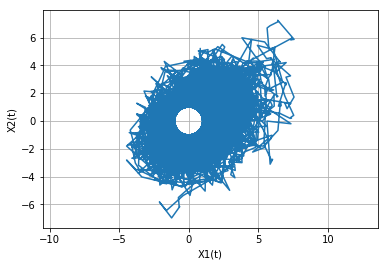

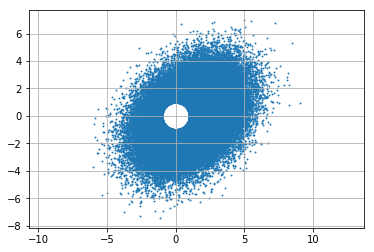

In [68]:
np.random.seed(134304)
%matplotlib inline
bps = BPS([2,2],2,np.array([1,0]),np.linalg.inv(np.array([[3,1],[1,3]])),5000,boundary = np.array([[0,0],1]))
bps.plot_path()

plt.scatter(Y[:,0],Y[:,1],s=0.8)
plt.axis('equal')
plt.grid(True)
plt.show()

In [173]:
def bps_simulation(x0,dim,mu,V,final_time,boundary): 
    
    # Control the total time
    current_time = 0

    # Initialize dataframes
    #T = pd.DataFrame(columns = ['T'])
    #X = pd.DataFrame(columns = range(dim))
    #theta = pd.DataFrame(columns = range(dim))
    
    dict_T = {'T':[]}
    dict_X = {'X':[]}
    dict_theta = {'theta':[]}
    
    dict_T['T'].append(0)
    dict_X['X'].append(x0)
    
    initial_theta = resample_velocity(dim)
    dict_theta['theta'].append(initial_theta.tolist())

    # Initial values
    #T.loc[1] = 0
    #X.loc[1,] = x0#[0]*self.dim
    #theta.loc[1,] = resample_velocity(dim)

    # Define the refresh rate
    refresh_rate = 1
    bounce = -1
    k = 1
    bound = np.nan
    
    current_X = x0
    current_theta = initial_theta

    while (current_time < final_time):
        
        # Draw uniform r.v. for switching time, refresh time and acceptance of new switching time
        R = np.random.uniform(0,1,[1,2])
        a = np.dot(current_theta,np.dot(V,current_X-mu))
        b = np.dot(current_theta,np.dot(V,current_theta))
        bounce = random_time(a,b,R[0,0])
        
        if boundary is not None:
            #print('x',X.loc[k,:])
            #print('v',theta.loc[k,:])
            bound = tau_bounce_sphere(np.array(current_X),np.array(current_theta),boundary[1],boundary[0])
            if bound<0:
                bound = np.nan
                    
        if (refresh_rate <= 0):
            refresh = -1
            print('Infinity')
            tau = bounce
        else:
            refresh = -np.log(R[0,1])/float(refresh_rate)
            #print('refresh',refresh)
            tau = np.nanmin([bounce,refresh,bound])
            
        #print(tau)
        # Update time and path
        #T.loc[k+1] = T.loc[k] + tau
        #X.loc[k+1,:] = X.loc[k,:] + theta.loc[k,:]*tau
        
        
        current_X = current_X + current_theta*tau
        
        
        dict_T['T'].append(current_time + tau)
        dict_X['X'].append(current_X.tolist())
        #theta.loc[k+1,:] = theta.loc[k,:]
        #print(X.loc[k+1,:])
            
        #print('Old v',theta.loc[k,:])
        if tau == refresh: # refresh
            update_theta = resample_velocity(dim)
            #theta.loc[k+1,:] = resample_velocity(dim)
        elif tau == bound: # bound
            n = normal_sphere(current_X,boundary[0])
            #print('n',n)
            update_theta = reflection(current_theta,n)
            #theta.loc[k+1,:] = reflection(theta.loc[k,:],n)
            #print('New v',theta.loc[k+1,:])
        else: # bounce
            update_theta = flip_BPS(current_X,current_theta,mu,V)
            #theta.loc[k+1,:] = flip_BPS(current_X.values,theta.loc[k,:].values,mu,V)
            
        k = k+1
        current_theta = update_theta
        dict_theta['theta'].append(current_theta.tolist())
        #current_time = T.loc[k].item()
        current_time = current_time + tau
    
    T = pd.DataFrame.from_dict(dict_T)
    X = pd.DataFrame.from_dict(dict_X)
    theta = pd.DataFrame.from_dict(dict_theta)
        
    return T,pd.DataFrame(X['X'].values.tolist()),pd.DataFrame(theta['theta'].values.tolist())

In [162]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [163]:
%lprun -f bps_simulation bps_simulation([2,2],2,np.array([1,0]),np.linalg.inv(np.array([[3,1],[1,3]])),5000,boundary = np.array([[0,0],1]))

In [188]:
T,X,theta = bps_simulation([2,2],2,np.array([1,0]),np.linalg.inv(np.array([[3,1],[1,3]])),100,boundary = np.array([[0,0],1]))

In [181]:
bps = BPS([2,2],2,np.array([1,0]),np.linalg.inv(np.array([[3,1],[1,3]])),100,boundary = np.array([[0,0],1]))

In [197]:
T.loc[135,:]

T    100.554676
Name: 135, dtype: float64

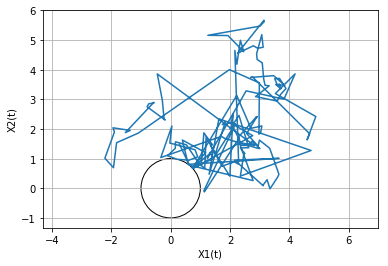

In [187]:
bps.plot_path()

In [10]:
def random_out_circle(radius = 1):
    r = 0
    while r<1:
        a = np.random.random() * 2 * np.pi
        r = radius * np.sqrt(10*np.random.random())
    
    x = r * np.cos(a)
    y = r * np.sin(a)
    return [x,y]

In [165]:
random_out_circle()

[1.3089865505785236, -1.4351114572157684]

In [200]:
def bias_means_bps(T,K,boundary):
    columns = ['bps_x','bps_y','mc_x','mc_y']
    index = range(0)
    bias_means_bps = pd.DataFrame(index = index, columns = columns)
    
    for i in range(0,K):
        bps = BPS(random_out_circle(radius = boundary[1]),2,np.array([1,0]),np.linalg.inv(np.array([[3,1],[1,3]])),T,boundary = boundary)
        Y = MC_conditional_prob(np.array([1,0]),np.array([[3,1],[1,3]]),T,1)
        
        mean_bps = bps.mean_and_covariance()[0]
        bias_means_bps.loc[i,'bps_x'] = mean_bps[0]
        bias_means_bps.loc[i,'bps_y'] = mean_bps[1]
        
        mean_mc = np.mean(Y,axis=0)
        bias_means_bps.loc[i,'mc_x'] = mean_mc[0]
        bias_means_bps.loc[i,'mc_y'] = mean_mc[1]
    return bias_means_bps

In [203]:
bias_means_df_100 = bias_means_bps(100,100,np.array([[0,0],1]))
#bias_means_df_500 = bias_means_bps(500,100,np.array([[0,0],1]))

In [204]:
bias_means_df_500 = bias_means_bps(500,100,np.array([[0,0],1]))

In [205]:
bias_means_df_1000 = bias_means_bps(1000,100,np.array([[0,0],1]))

In [151]:
#plt.plot(bias_means_df['bps_x'],bias_means_df['bps_y'],'o',label = 'Bouncy Particle Sampler')
#plt.plot(bias_means_df['mc_x'],bias_means_df['mc_y'],'o',label = 'Standard MC')
#plt.axis('equal')
#plt.legend(loc='best')
#plt.grid(True)
#plt.rcParams["figure.figsize"] = 1,1
#plt.title('T=100')
#plt.show()

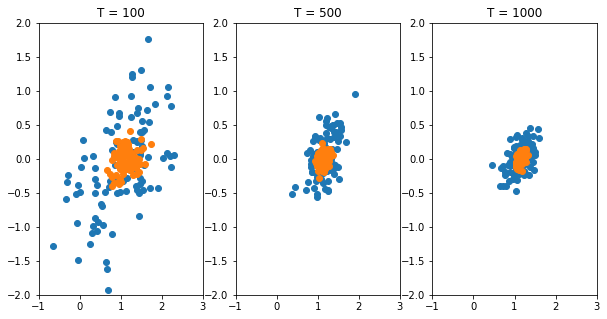

In [206]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(131)
ax1.plot(bias_means_df_100['bps_x'],bias_means_df_100['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax1.plot(bias_means_df_100['mc_x'],bias_means_df_100['mc_y'],'o',label = 'Standard MC')
ax1.set_xlim([-1,3])
ax1.set_ylim([-2,2])

ax2 = fig.add_subplot(132)
ax2.plot(bias_means_df_500['bps_x'],bias_means_df_500['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax2.plot(bias_means_df_500['mc_x'],bias_means_df_500['mc_y'],'o',label = 'Standard MC')
ax2.set_xlim([-1,3])
ax2.set_ylim([-2,2])

ax3 = fig.add_subplot(133)
ax3.plot(bias_means_df_1000['bps_x'],bias_means_df_1000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax3.plot(bias_means_df_1000['mc_x'],bias_means_df_1000['mc_y'],'o',label = 'Standard MC')
ax3.set_xlim([-1,3])
ax3.set_ylim([-2,2])

ax1.title.set_text('T = 100')
ax2.title.set_text('T = 500')
ax3.title.set_text('T = 1000')
plt.show()

In [26]:
np.random.seed(2358942)
columns = ['T','error']
index = range(0)
df_mean_bps_mc = pd.DataFrame(index = index, columns = columns)
T = [100,200,500,1000,5000]
K = 50
j = -1

for t in T:
    j = j+1
    mean_bps = np.array([0,0])
    for i in range(0,K):
        Y = MC_conditional_prob(np.array([1,0]),np.array([[3,1],[1,3]]),t,1)
        df_mean_bps_mc.loc[i+K*j,'T'] = t
        df_mean_bps_mc.loc[i+K*j,'error'] = np.sum((np.mean(Y,axis=0)-np.array([1,0]))**2)

In [73]:
#df_mean_bps_mc;
#df_mean_bps_mc.boxplot(column='error', by='T')
#plt.axhline(y=chi2.sf(6*np.sqrt(2*4)+4,4), color='r', linestyle='-')
#plt.title('')
#plt.yscale('log')
#plt.show()

In [28]:
def means_BPS(T,K):
    columns = ['T','error']
    index = range(0)
    df_mean_bps = pd.DataFrame(index = index, columns = columns)
    j = -1

    for t in T:
        j = j+1
        mean_bps = np.array([0,0])
        for i in range(0,K):
            bps = BPS([2,2],2,np.array([1,0]),np.linalg.inv(np.array([[3,1],[1,3]])),t,boundary = np.array([[0,0],1]))
            mean_bps = bps.mean_and_covariance()[0]
            df_mean_bps.loc[i+10*j,'T'] = t
            df_mean_bps.loc[i+10*j,'error'] = np.sum((mean_bps-np.array([1,0]))**2)
    return df_mean_bps

In [29]:
mean_results = means_BPS([100,200,500,1000,5000],25)

In [30]:
mean_results.to_csv('mean_results.csv',index=False)

In [51]:
dfmean_bps = pd.read_csv ('C:\Users\mark\Documents\TU Delft\Master thesis\Notebooks\dfmean_bps.csv')

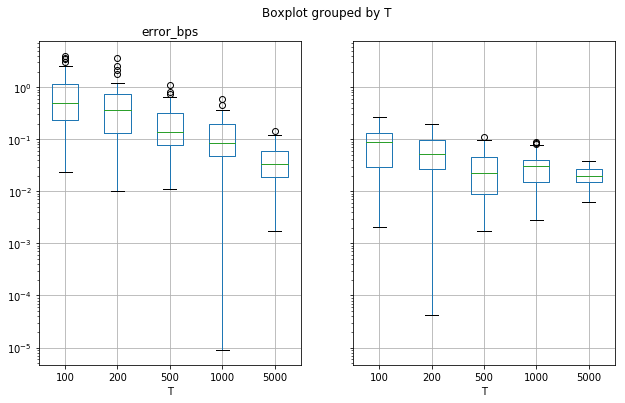

In [72]:
cdf = pd.concat([dfmean_bps,df_mean_bps_mc],axis=1)
plt.rcParams["figure.figsize"] = 10,6
cdf.boxplot(column=['error_bps','error'], by='T')
#plt.axhline(y=chi2.sf(6*np.sqrt(2*4)+4,4), color='r', linestyle='-')
plt.title('')
plt.yscale('log')
plt.show()

In [20]:
np.random.seed(20)
Y = MC_conditional_prob(np.array([0,0]),np.array([[1,0],[0,1]]),100000,16)

### Conditional distribution and convergence

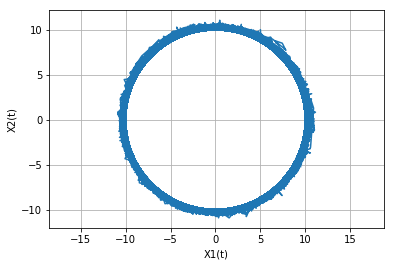

In [65]:
#np.random.seed(134304)
%matplotlib inline
bps = BPS([5,10],2,np.array([0,0]),np.linalg.inv(np.array([[1,0],[0,1]])),100000,boundary = np.array([[0,0],10]))
bps.plot_path()

#plt.scatter(Y[:,0],Y[:,1],s=0.8)
#plt.axis('equal')
#plt.grid(True)
#plt.show()

In [66]:
S = bps.sample_traj(10000)

In [67]:
np.mean(S)

0    0.305950
1   -0.268824
dtype: float64

In [68]:
np.cov(S.loc[:,0],S.loc[:,1])

array([[49.773510403875534, -1.2235148274650962],
       [-1.2235148274650962, 52.15523641404343]], dtype=object)

In [210]:
bias_means_df_100 = bias_means_bps(100,100,boundary = np.array([[0,0],4]))

In [211]:
bias_means_df_500 = bias_means_bps(500,100,boundary = np.array([[0,0],4]))

In [212]:
bias_means_df_1000 = bias_means_bps(1000,100,boundary = np.array([[0,0],4]))

In [215]:
bias_means_df_5000 = bias_means_bps(5000,100,boundary = np.array([[0,0],4]))

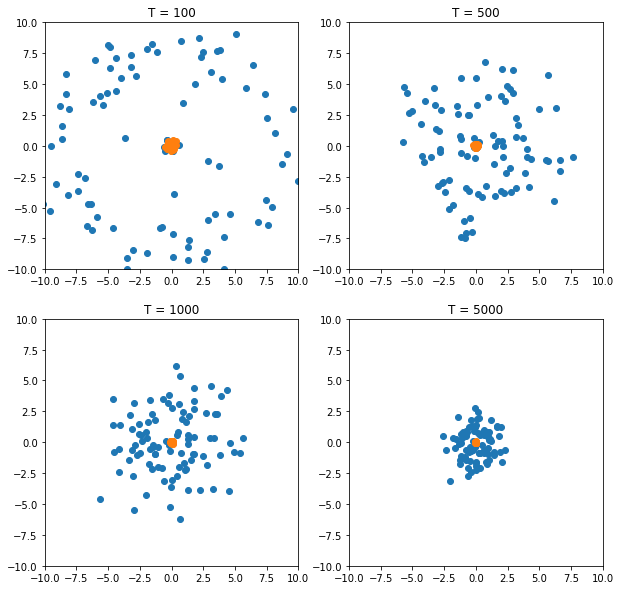

In [269]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221)
ax1.plot(bias_means_df_100['bps_x'],bias_means_df_100['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax1.plot(bias_means_df_100['mc_x'],bias_means_df_100['mc_y'],'o',label = 'Standard MC')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

ax2 = fig.add_subplot(222)
ax2.plot(bias_means_df_500['bps_x'],bias_means_df_500['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax2.plot(bias_means_df_500['mc_x'],bias_means_df_500['mc_y'],'o',label = 'Standard MC')
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])

ax3 = fig.add_subplot(223)
ax3.plot(bias_means_df_1000['bps_x'],bias_means_df_1000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax3.plot(bias_means_df_1000['mc_x'],bias_means_df_1000['mc_y'],'o',label = 'Standard MC')
ax3.set_xlim([-10,10])
ax3.set_ylim([-10,10])

ax4 = fig.add_subplot(224)
ax4.plot(bias_means_df_5000['bps_x'],bias_means_df_5000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax4.plot(bias_means_df_5000['mc_x'],bias_means_df_5000['mc_y'],'o',label = 'Standard MC')
ax4.set_xlim([-10,10])
ax4.set_ylim([-10,10])

ax1.title.set_text('T = 100')
ax2.title.set_text('T = 500')
ax3.title.set_text('T = 1000')
ax4.title.set_text('T = 5000')
plt.show()

In [217]:
bias_means_df_100 = bias_means_bps(100,100,boundary = np.array([[0,0],9]))

In [218]:
bias_means_df_500 = bias_means_bps(500,100,boundary = np.array([[0,0],9]))

In [219]:
bias_means_df_1000 = bias_means_bps(1000,100,boundary = np.array([[0,0],9]))

In [221]:
bias_means_df_5000 = bias_means_bps(5000,100,boundary = np.array([[0,0],9]))

In [223]:
bias_means_df_10000 = bias_means_bps(10000,100,boundary = np.array([[0,0],9]))

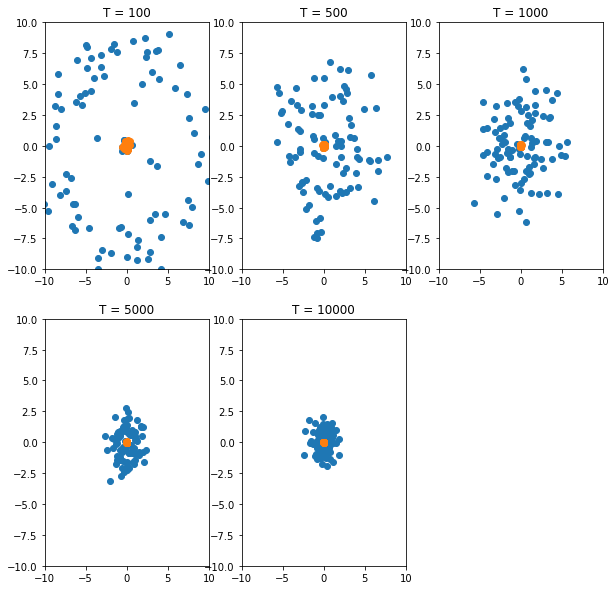

In [271]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(231)
ax1.plot(bias_means_df_100['bps_x'],bias_means_df_100['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax1.plot(bias_means_df_100['mc_x'],bias_means_df_100['mc_y'],'o',label = 'Standard MC')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

ax2 = fig.add_subplot(232)
ax2.plot(bias_means_df_500['bps_x'],bias_means_df_500['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax2.plot(bias_means_df_500['mc_x'],bias_means_df_500['mc_y'],'o',label = 'Standard MC')
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])

ax3 = fig.add_subplot(233)
ax3.plot(bias_means_df_1000['bps_x'],bias_means_df_1000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax3.plot(bias_means_df_1000['mc_x'],bias_means_df_1000['mc_y'],'o',label = 'Standard MC')
ax3.set_xlim([-10,10])
ax3.set_ylim([-10,10])

ax4 = fig.add_subplot(234)
ax4.plot(bias_means_df_5000['bps_x'],bias_means_df_5000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax4.plot(bias_means_df_5000['mc_x'],bias_means_df_5000['mc_y'],'o',label = 'Standard MC')
ax4.set_xlim([-10,10])
ax4.set_ylim([-10,10])

ax5 = fig.add_subplot(235)
ax5.plot(bias_means_df_10000['bps_x'],bias_means_df_10000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax5.plot(bias_means_df_10000['mc_x'],bias_means_df_10000['mc_y'],'o',label = 'Standard MC')
ax5.set_xlim([-10,10])
ax5.set_ylim([-10,10])

ax1.title.set_text('T = 100')
ax2.title.set_text('T = 500')
ax3.title.set_text('T = 1000')
ax4.title.set_text('T = 5000')
ax5.title.set_text('T = 10000')
plt.show()

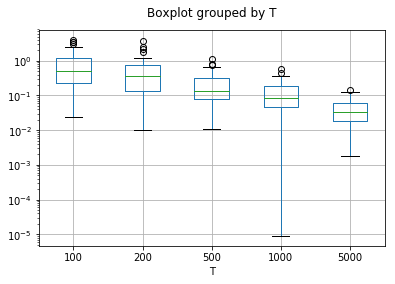

In [33]:
dfmean_bps.boxplot(column='error_bps', by='T')
#plt.axhline(y=chi2.sf(6*np.sqrt(2*4)+4,4), color='r', linestyle='-')
plt.title('')
plt.yscale('log')
plt.show()

In [238]:
Y = MC_conditional_prob(np.array([0,0]),np.array([[1,0],[0,1]]),100000,1)

In [246]:
def bias_means_bps(T,K,boundary):
    columns = ['bps_x','bps_y','mc_x','mc_y']
    index = range(0)
    bias_means_bps = pd.DataFrame(index = index, columns = columns)
    
    for i in range(0,K):
        bps = BPS(random_out_circle(radius = boundary[1]),2,np.array([0,0]),np.linalg.inv(np.array([[1,0],[0,1]])),T,boundary = boundary)
        Y = MC_conditional_prob(np.array([0,0]),np.array([[1,0],[0,1]]),T,1)
        
        mean_bps = bps.mean_and_covariance()[0]
        bias_means_bps.loc[i,'bps_x'] = mean_bps[0]
        bias_means_bps.loc[i,'bps_y'] = mean_bps[1]
        
        mean_mc = np.mean(Y,axis=0)
        bias_means_bps.loc[i,'mc_x'] = mean_mc[0]
        bias_means_bps.loc[i,'mc_y'] = mean_mc[1]
    return bias_means_bps

In [247]:
bias_means_df_100 = bias_means_bps(100,100,np.array([[0,0],1]))

In [248]:
bias_means_df_500 = bias_means_bps(500,100,np.array([[0,0],1]))

In [249]:
bias_means_df_1000 = bias_means_bps(1000,100,np.array([[0,0],1]))

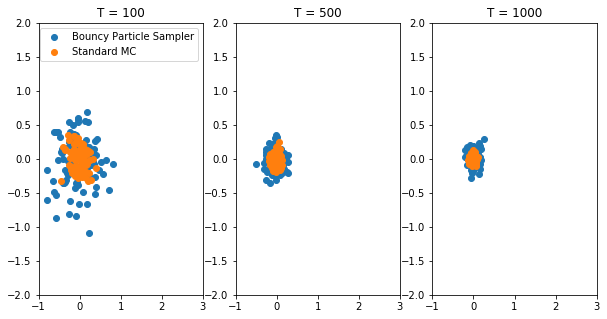

In [250]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(131)
ax1.plot(bias_means_df_100['bps_x'],bias_means_df_100['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax1.plot(bias_means_df_100['mc_x'],bias_means_df_100['mc_y'],'o',label = 'Standard MC')
ax1.set_xlim([-1,3])
ax1.set_ylim([-2,2])
ax1.legend(loc='best')

ax2 = fig.add_subplot(132)
ax2.plot(bias_means_df_500['bps_x'],bias_means_df_500['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax2.plot(bias_means_df_500['mc_x'],bias_means_df_500['mc_y'],'o',label = 'Standard MC')
ax2.set_xlim([-1,3])
ax2.set_ylim([-2,2])

ax3 = fig.add_subplot(133)
ax3.plot(bias_means_df_1000['bps_x'],bias_means_df_1000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax3.plot(bias_means_df_1000['mc_x'],bias_means_df_1000['mc_y'],'o',label = 'Standard MC')
ax3.set_xlim([-1,3])
ax3.set_ylim([-2,2])

ax1.title.set_text('T = 100')
ax2.title.set_text('T = 500')
ax3.title.set_text('T = 1000')
plt.show()

In [251]:
bias_means_df_100 = bias_means_bps(100,100,boundary = np.array([[0,0],4]))

In [252]:
bias_means_df_500 = bias_means_bps(500,100,boundary = np.array([[0,0],4]))

In [253]:
bias_means_df_1000 = bias_means_bps(1000,100,boundary = np.array([[0,0],4]))

In [254]:
bias_means_df_5000 = bias_means_bps(5000,100,boundary = np.array([[0,0],4]))

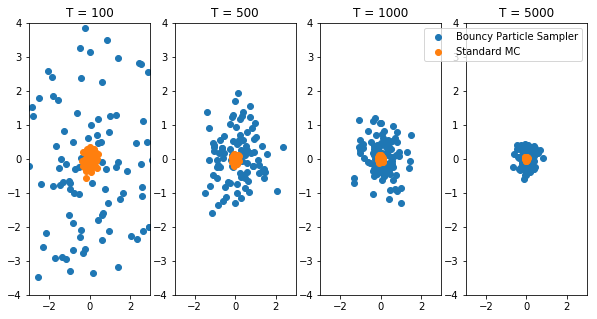

In [259]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(141)
ax1.plot(bias_means_df_100['bps_x'],bias_means_df_100['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax1.plot(bias_means_df_100['mc_x'],bias_means_df_100['mc_y'],'o',label = 'Standard MC')
ax1.set_xlim([-3,3])
ax1.set_ylim([-4,4])


ax2 = fig.add_subplot(142)
ax2.plot(bias_means_df_500['bps_x'],bias_means_df_500['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax2.plot(bias_means_df_500['mc_x'],bias_means_df_500['mc_y'],'o',label = 'Standard MC')
ax2.set_xlim([-3,3])
ax2.set_ylim([-4,4])

ax3 = fig.add_subplot(143)
ax3.plot(bias_means_df_1000['bps_x'],bias_means_df_1000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax3.plot(bias_means_df_1000['mc_x'],bias_means_df_1000['mc_y'],'o',label = 'Standard MC')
ax3.set_xlim([-3,3])
ax3.set_ylim([-4,4])

ax4 = fig.add_subplot(144)
ax4.plot(bias_means_df_5000['bps_x'],bias_means_df_5000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax4.plot(bias_means_df_5000['mc_x'],bias_means_df_5000['mc_y'],'o',label = 'Standard MC')
ax4.set_xlim([-3,3])
ax4.set_ylim([-4,4])
ax4.legend(loc='best')

ax1.title.set_text('T = 100')
ax2.title.set_text('T = 500')
ax3.title.set_text('T = 1000')
ax4.title.set_text('T = 5000')
plt.show()

In [260]:
bias_means_df_100 = bias_means_bps(100,100,boundary = np.array([[0,0],9]))

In [261]:
bias_means_df_500 = bias_means_bps(500,100,boundary = np.array([[0,0],9]))

In [262]:
bias_means_df_1000 = bias_means_bps(1000,100,boundary = np.array([[0,0],9]))

In [263]:
bias_means_df_5000 = bias_means_bps(5000,100,boundary = np.array([[0,0],9]))

In [264]:
bias_means_df_10000 = bias_means_bps(10000,100,boundary = np.array([[0,0],9]))

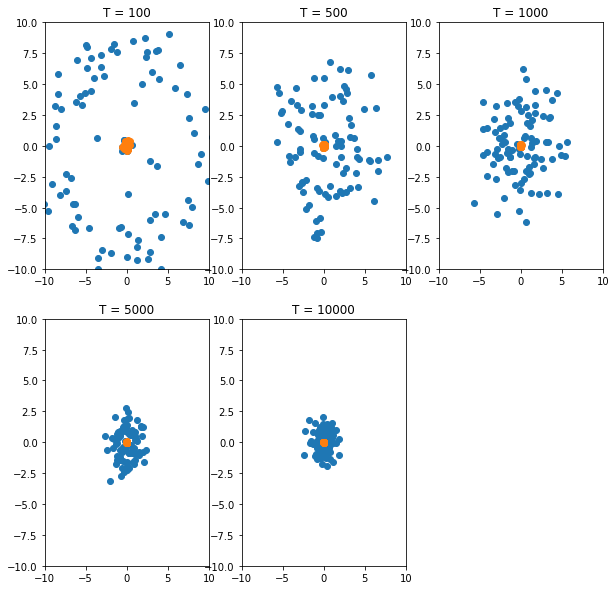

In [272]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(231)
ax1.plot(bias_means_df_100['bps_x'],bias_means_df_100['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax1.plot(bias_means_df_100['mc_x'],bias_means_df_100['mc_y'],'o',label = 'Standard MC')
ax1.set_xlim([-10,10])
ax1.set_ylim([-10,10])

ax2 = fig.add_subplot(232)
ax2.plot(bias_means_df_500['bps_x'],bias_means_df_500['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax2.plot(bias_means_df_500['mc_x'],bias_means_df_500['mc_y'],'o',label = 'Standard MC')
ax2.set_xlim([-10,10])
ax2.set_ylim([-10,10])

ax3 = fig.add_subplot(233)
ax3.plot(bias_means_df_1000['bps_x'],bias_means_df_1000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax3.plot(bias_means_df_1000['mc_x'],bias_means_df_1000['mc_y'],'o',label = 'Standard MC')
ax3.set_xlim([-10,10])
ax3.set_ylim([-10,10])

ax4 = fig.add_subplot(234)
ax4.plot(bias_means_df_5000['bps_x'],bias_means_df_5000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax4.plot(bias_means_df_5000['mc_x'],bias_means_df_5000['mc_y'],'o',label = 'Standard MC')
ax4.set_xlim([-10,10])
ax4.set_ylim([-10,10])

ax5 = fig.add_subplot(235)
ax5.plot(bias_means_df_10000['bps_x'],bias_means_df_10000['bps_y'],'o',label = 'Bouncy Particle Sampler')
ax5.plot(bias_means_df_10000['mc_x'],bias_means_df_10000['mc_y'],'o',label = 'Standard MC')
ax5.set_xlim([-10,10])
ax5.set_ylim([-10,10])

ax1.title.set_text('T = 100')
ax2.title.set_text('T = 500')
ax3.title.set_text('T = 1000')
ax4.title.set_text('T = 5000')
ax5.title.set_text('T = 10000')
plt.show()